<a href="https://colab.research.google.com/github/MisatoYasuda/Coursera/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Submission

update the predition and then run this line to get the newest output

In [ ]:
prediction = pd.concat([test.Id, pd.DataFrame(br.predict(X_test)**4, columns=['cnt'])], axis=1)
prediction.to_csv('/content/drive/MyDrive/ML_Project/sub.csv', index=False)


## Submissions and Public Scores

1.   "KNeighborsRegressor(n_neighbors=5, metric='l1')", **73.51502**
2.   "BaggingRegressor(DecisionTreeRegressor(), n_estimators=150, max_samples=0.6)", **52.22800**
3.   "BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, oob_score=True, random_state=1)", **51.44858**
4.   the same model as 3 with an extra feature: 'day of the month': **52.52376**
5.  changed dteday to milliseconds/1e11 "RandomForestRegressor(n_estimators=2000, max_features=0.6, oob_score=True, random_state=1)" **49.71162**
6.  transform cnt with power 0.25 for prediction the same model as 3, **51.28888**
7.  Neural Networks (?) **58.55916**

# Introduction



*   Background
*   Identification of the prediction problem
*   Overall info about the dataset
*   Models used
*  Result

Everything in a nutshell.



# Import data

In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# List files in a specific directory
path_train = "/content/drive/MyDrive/ML_Project/train.csv"
path_test = "/content/drive/MyDrive/ML_Project/test.csv"

Mounted at /content/drive


In [3]:
train = pd.read_csv(path_train, parse_dates=['dteday'])

In [4]:
test = pd.read_csv(path_test, parse_dates=['dteday'])

# Exploratory Data Analysis

## General view of the data

In [ ]:
train.head()

,Id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,2011-01-01,Winter,2011.0,January,0.0,No,Saturday,No,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,NaN,0.0,16
1,2,2011-01-01,Winter,2011.0,January,1.0,No,Saturday,No,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,40
2,3,2011-01-01,Winter,2011.0,January,2.0,No,Saturday,No,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,32
3,4,2011-01-01,Winter,2011.0,January,3.0,No,Saturday,No,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,13
4,5,2011-01-01,Winter,2011.0,January,4.0,No,Saturday,No,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,1


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15211 entries, 0 to 15210
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Id          15211 non-null  int64         
 1   dteday      15180 non-null  datetime64[ns]
 2   season      15166 non-null  object        
 3   yr          15174 non-null  float64       
 4   mnth        15175 non-null  object        
 5   hr          15185 non-null  float64       
 6   holiday     15179 non-null  object        
 7   weekday     15171 non-null  object        
 8   workingday  15181 non-null  object        
 9   weathersit  15180 non-null  object        
 10  temp        15027 non-null  float64       
 11  atemp       15030 non-null  float64       
 12  hum         15054 non-null  float64       
 13  windspeed   15047 non-null  float64       
 14  cnt         15211 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(2), object(6)
memory usage: 1.

In [ ]:
pd.DataFrame([train.isna().sum().to_dict()])

,Id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,0,31,45,37,36,26,32,40,30,31,184,181,157,164,0


In [ ]:
train.isna().sum().sum() > len(train) * 0.05

True

**The number of missing values exceeds 5% of the total number of samples. We cannot directly remove the NAs.**

## Data cleaning

- remove/replace nulls
- validate

In [ ]:
train.groupby("hr").count()

,Id,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
hr,,,,,,,,,,,,,,
0.0,634,633,632,632,632,633,634,634,634,624,623,627,628,634
1.0,634,632,634,633,633,634,633,631,632,627,626,629,628,634
2.0,623,621,621,620,623,622,623,620,623,616,616,617,616,623
3.0,610,610,608,607,610,610,607,609,609,601,603,605,599,610
4.0,605,604,603,602,605,603,601,603,605,594,599,597,597,605
5.0,624,624,622,622,621,622,622,624,621,616,615,622,619,624
6.0,635,633,634,634,634,632,635,635,634,626,627,630,630,635
7.0,636,633,635,636,635,635,635,633,634,629,628,631,628,636
8.0,635,634,635,632,632,632,633,632,635,626,629,634,628,635


In [ ]:
pd.date_range(start = '2011-01-01', end = '2012-09-30').difference(train.dteday.dropna())

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

We don't seem to have missing dates. Removing NA's causes incomplete date/time information.
-> Replace NA's or deep learning techniqurs (??).

**Data cleaning possibilities**
- Remove NA's
- Replace NA's (with average of neighbours?)
- Complete the variable `hr` so to have 24 observations per day -> Time series like analysis
-

### 1. Remove NA's in date

In [5]:
# drop NAs in dteday
train.dropna(subset=['dteday', 'hr'], inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15154 entries, 0 to 15210
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Id          15154 non-null  int64         
 1   dteday      15154 non-null  datetime64[ns]
 2   season      15109 non-null  object        
 3   yr          15118 non-null  float64       
 4   mnth        15119 non-null  object        
 5   hr          15154 non-null  float64       
 6   holiday     15123 non-null  object        
 7   weekday     15114 non-null  object        
 8   workingday  15124 non-null  object        
 9   weathersit  15123 non-null  object        
 10  temp        14970 non-null  float64       
 11  atemp       14975 non-null  float64       
 12  hum         14997 non-null  float64       
 13  windspeed   14990 non-null  float64       
 14  cnt         15154 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(2), object(6)
memory usage: 1.8+ MB

### 2. Validate and impute season, year, month, holiday, weekday, workingday

In [6]:
def validate_day(col):
    # get the unique combination of dteday and season/workingday/holiday
    df = train[['dteday', col]]
    # for later storing the map of season/workingday/holiday info to the NA celss
    map = {}
    # iterate through the dates that has NA cell in season/workingday/holiday column
    for d in set(df[df[col].isna()].dteday):
        # slice of specific date
        dfs = df[df.dteday==d]
        # check if there is season/workingday/holiday info for this date
        if dfs[col].notnull().sum() == 0:
            print(d, 'does not have {} info'.format(col))
        # check if the info is unique
        if len(set(dfs[dfs[col].notnull()][col])) > 1:
            print(d, 'is recorded', set(dfs[dfs[col].notnull()][col]))
        # store the uniqe info for this date
        map[d] = list(dfs[dfs[col].notnull()][col])[0]
    return map

def impute_day(col):
    map = validate_day(col)
    mask = train[col].isna()
    train.loc[mask, col] = train[mask].dteday.replace(map)
    return train.info()


In [7]:
impute_day('season')

<class 'pandas.core.frame.DataFrame'>
Index: 15154 entries, 0 to 15210
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Id          15154 non-null  int64         
 1   dteday      15154 non-null  datetime64[ns]
 2   season      15154 non-null  object        
 3   yr          15118 non-null  float64       
 4   mnth        15119 non-null  object        
 5   hr          15154 non-null  float64       
 6   holiday     15123 non-null  object        
 7   weekday     15114 non-null  object        
 8   workingday  15124 non-null  object        
 9   weathersit  15123 non-null  object        
 10  temp        14970 non-null  float64       
 11  atemp       14975 non-null  float64       
 12  hum         14997 non-null  float64       
 13  windspeed   14990 non-null  float64       
 14  cnt         15154 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(2), object(6)
memory usage: 1.8+ MB

In [8]:
impute_day('yr')

<class 'pandas.core.frame.DataFrame'>
Index: 15154 entries, 0 to 15210
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Id          15154 non-null  int64         
 1   dteday      15154 non-null  datetime64[ns]
 2   season      15154 non-null  object        
 3   yr          15154 non-null  float64       
 4   mnth        15119 non-null  object        
 5   hr          15154 non-null  float64       
 6   holiday     15123 non-null  object        
 7   weekday     15114 non-null  object        
 8   workingday  15124 non-null  object        
 9   weathersit  15123 non-null  object        
 10  temp        14970 non-null  float64       
 11  atemp       14975 non-null  float64       
 12  hum         14997 non-null  float64       
 13  windspeed   14990 non-null  float64       
 14  cnt         15154 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(2), object(6)
memory usage: 1.8+ MB

<ipython-input-6-51264a916a0d>:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train.loc[mask, col] = train[mask].dteday.replace(map)


In [9]:
impute_day('mnth')

<class 'pandas.core.frame.DataFrame'>
Index: 15154 entries, 0 to 15210
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Id          15154 non-null  int64         
 1   dteday      15154 non-null  datetime64[ns]
 2   season      15154 non-null  object        
 3   yr          15154 non-null  float64       
 4   mnth        15154 non-null  object        
 5   hr          15154 non-null  float64       
 6   holiday     15123 non-null  object        
 7   weekday     15114 non-null  object        
 8   workingday  15124 non-null  object        
 9   weathersit  15123 non-null  object        
 10  temp        14970 non-null  float64       
 11  atemp       14975 non-null  float64       
 12  hum         14997 non-null  float64       
 13  windspeed   14990 non-null  float64       
 14  cnt         15154 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(2), object(6)
memory usage: 1.8+ MB

In [10]:
impute_day('holiday')

<class 'pandas.core.frame.DataFrame'>
Index: 15154 entries, 0 to 15210
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Id          15154 non-null  int64         
 1   dteday      15154 non-null  datetime64[ns]
 2   season      15154 non-null  object        
 3   yr          15154 non-null  float64       
 4   mnth        15154 non-null  object        
 5   hr          15154 non-null  float64       
 6   holiday     15154 non-null  object        
 7   weekday     15114 non-null  object        
 8   workingday  15124 non-null  object        
 9   weathersit  15123 non-null  object        
 10  temp        14970 non-null  float64       
 11  atemp       14975 non-null  float64       
 12  hum         14997 non-null  float64       
 13  windspeed   14990 non-null  float64       
 14  cnt         15154 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(2), object(6)
memory usage: 1.8+ MB

In [11]:
impute_day('weekday')

<class 'pandas.core.frame.DataFrame'>
Index: 15154 entries, 0 to 15210
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Id          15154 non-null  int64         
 1   dteday      15154 non-null  datetime64[ns]
 2   season      15154 non-null  object        
 3   yr          15154 non-null  float64       
 4   mnth        15154 non-null  object        
 5   hr          15154 non-null  float64       
 6   holiday     15154 non-null  object        
 7   weekday     15154 non-null  object        
 8   workingday  15124 non-null  object        
 9   weathersit  15123 non-null  object        
 10  temp        14970 non-null  float64       
 11  atemp       14975 non-null  float64       
 12  hum         14997 non-null  float64       
 13  windspeed   14990 non-null  float64       
 14  cnt         15154 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(2), object(6)
memory usage: 1.8+ MB

In [12]:
impute_day('workingday')

<class 'pandas.core.frame.DataFrame'>
Index: 15154 entries, 0 to 15210
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Id          15154 non-null  int64         
 1   dteday      15154 non-null  datetime64[ns]
 2   season      15154 non-null  object        
 3   yr          15154 non-null  float64       
 4   mnth        15154 non-null  object        
 5   hr          15154 non-null  float64       
 6   holiday     15154 non-null  object        
 7   weekday     15154 non-null  object        
 8   workingday  15154 non-null  object        
 9   weathersit  15123 non-null  object        
 10  temp        14970 non-null  float64       
 11  atemp       14975 non-null  float64       
 12  hum         14997 non-null  float64       
 13  windspeed   14990 non-null  float64       
 14  cnt         15154 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(2), object(6)
memory usage: 1.8+ MB

### 3. Validate and impute weathersit, temp, atemp, hum, windspeed

In [13]:
# use the value of last 2 hours or next 2 hours to impute temp, atemp, hum, and windspeed
def impute_weather(col):
    m = {}
    while train[col].isna().sum() > 0:
        for id, row in train[train[col].isna()].iterrows():
            d, h = row['dteday'], row['hr']
            h1 = train[train.dteday==d].loc[train.hr==h-1, col].values
            h2 = train[train.dteday==d].loc[train.hr==h+1, col].values
            h3 = train[train.dteday==d].loc[train.hr==h-2, col].values
            h4 = train[train.dteday==d].loc[train.hr==h+2, col].values
            if len(h1) > 0:
                m[id] = h1[0]
            elif len(h2) > 0:
                m[id] = h2[0]
            elif len(h3) > 0:
                m[id] = h3[0]
            elif len(h4) > 0:
                m[id] = h4[0]
        train.loc[train[col].isna(), col] = pd.Series(m)
    return train.info()

In [14]:
impute_weather('weathersit')

<class 'pandas.core.frame.DataFrame'>
Index: 15154 entries, 0 to 15210
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Id          15154 non-null  int64         
 1   dteday      15154 non-null  datetime64[ns]
 2   season      15154 non-null  object        
 3   yr          15154 non-null  float64       
 4   mnth        15154 non-null  object        
 5   hr          15154 non-null  float64       
 6   holiday     15154 non-null  object        
 7   weekday     15154 non-null  object        
 8   workingday  15154 non-null  object        
 9   weathersit  15154 non-null  object        
 10  temp        14970 non-null  float64       
 11  atemp       14975 non-null  float64       
 12  hum         14997 non-null  float64       
 13  windspeed   14990 non-null  float64       
 14  cnt         15154 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(2), object(6)
memory usage: 2.4+ MB

In [15]:
impute_weather('temp')

<class 'pandas.core.frame.DataFrame'>
Index: 15154 entries, 0 to 15210
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Id          15154 non-null  int64         
 1   dteday      15154 non-null  datetime64[ns]
 2   season      15154 non-null  object        
 3   yr          15154 non-null  float64       
 4   mnth        15154 non-null  object        
 5   hr          15154 non-null  float64       
 6   holiday     15154 non-null  object        
 7   weekday     15154 non-null  object        
 8   workingday  15154 non-null  object        
 9   weathersit  15154 non-null  object        
 10  temp        15154 non-null  float64       
 11  atemp       14975 non-null  float64       
 12  hum         14997 non-null  float64       
 13  windspeed   14990 non-null  float64       
 14  cnt         15154 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(2), object(6)
memory usage: 2.4+ MB

In [16]:
impute_weather('atemp')

<class 'pandas.core.frame.DataFrame'>
Index: 15154 entries, 0 to 15210
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Id          15154 non-null  int64         
 1   dteday      15154 non-null  datetime64[ns]
 2   season      15154 non-null  object        
 3   yr          15154 non-null  float64       
 4   mnth        15154 non-null  object        
 5   hr          15154 non-null  float64       
 6   holiday     15154 non-null  object        
 7   weekday     15154 non-null  object        
 8   workingday  15154 non-null  object        
 9   weathersit  15154 non-null  object        
 10  temp        15154 non-null  float64       
 11  atemp       15154 non-null  float64       
 12  hum         14997 non-null  float64       
 13  windspeed   14990 non-null  float64       
 14  cnt         15154 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(2), object(6)
memory usage: 2.4+ MB

In [17]:
impute_weather('hum')

<class 'pandas.core.frame.DataFrame'>
Index: 15154 entries, 0 to 15210
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Id          15154 non-null  int64         
 1   dteday      15154 non-null  datetime64[ns]
 2   season      15154 non-null  object        
 3   yr          15154 non-null  float64       
 4   mnth        15154 non-null  object        
 5   hr          15154 non-null  float64       
 6   holiday     15154 non-null  object        
 7   weekday     15154 non-null  object        
 8   workingday  15154 non-null  object        
 9   weathersit  15154 non-null  object        
 10  temp        15154 non-null  float64       
 11  atemp       15154 non-null  float64       
 12  hum         15154 non-null  float64       
 13  windspeed   14990 non-null  float64       
 14  cnt         15154 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(2), object(6)
memory usage: 2.4+ MB

In [18]:
impute_weather('windspeed')

<class 'pandas.core.frame.DataFrame'>
Index: 15154 entries, 0 to 15210
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Id          15154 non-null  int64         
 1   dteday      15154 non-null  datetime64[ns]
 2   season      15154 non-null  object        
 3   yr          15154 non-null  float64       
 4   mnth        15154 non-null  object        
 5   hr          15154 non-null  float64       
 6   holiday     15154 non-null  object        
 7   weekday     15154 non-null  object        
 8   workingday  15154 non-null  object        
 9   weathersit  15154 non-null  object        
 10  temp        15154 non-null  float64       
 11  atemp       15154 non-null  float64       
 12  hum         15154 non-null  float64       
 13  windspeed   15154 non-null  float64       
 14  cnt         15154 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(2), object(6)
memory usage: 2.4+ MB

### !!! change dteday to milliseconds

In [19]:
train['dteday'] = train.dteday.astype('int')/1e11
train.head()

,Id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,12938400.0,Winter,2011.0,January,0.0,No,Saturday,No,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.80,0.0,16
1,2,12938400.0,Winter,2011.0,January,1.0,No,Saturday,No,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,40
2,3,12938400.0,Winter,2011.0,January,2.0,No,Saturday,No,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,32
3,4,12938400.0,Winter,2011.0,January,3.0,No,Saturday,No,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,13
4,5,12938400.0,Winter,2011.0,January,4.0,No,Saturday,No,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,1


In [ ]:
train.tail()

,Id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
15206,15207,13489632.0,Fall,2012.0,September,19.0,No,Sunday,No,"Light Snow, Light Rain + Thunderstorm + Scatte...",0.50,0.4848,0.72,0.1343,257
15207,15208,13489632.0,Fall,2012.0,September,20.0,No,Sunday,No,"Light Snow, Light Rain + Thunderstorm + Scatte...",0.50,0.4848,0.72,0.1343,194
15208,15209,13489632.0,Fall,2012.0,September,21.0,No,Sunday,No,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.50,0.4848,0.68,0.0000,123
15209,15210,13489632.0,Fall,2012.0,September,22.0,No,Sunday,No,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.48,0.4697,0.72,0.0000,91
15210,15211,13489632.0,Fall,2012.0,September,23.0,No,Sunday,No,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.48,0.4697,0.72,0.0896,57


## Visualization

<Axes: >

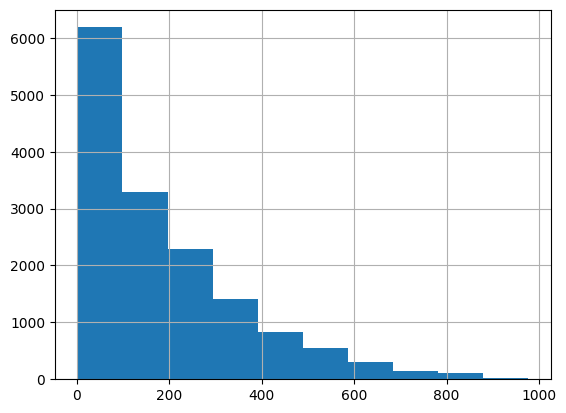

In [ ]:
train.cnt.hist()

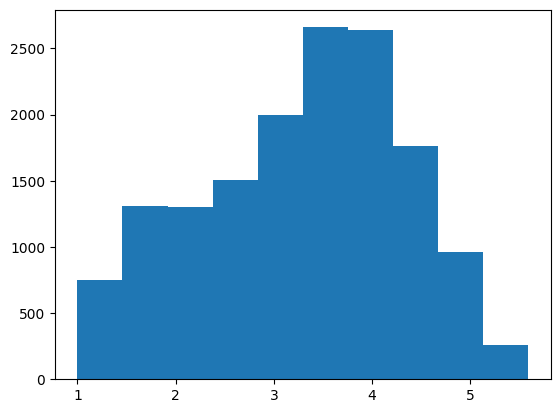

In [ ]:
plt.hist(train.cnt ** 0.25)
plt.show()

# Encoding

- here the dteday is directly removed only having its freatures, mnth, weekday, ... representation in the data
- may consider other ways of encoding the datetime object

In [20]:
train.astype({'season':'category', 'weekday':'category', 'weathersit':'category'})
X = pd.get_dummies(train, drop_first=True).drop(['Id', 'cnt'], axis=1)
y = train.cnt

In [21]:
test['dteday'] = test.dteday.astype('int')/1e11
X_test = pd.get_dummies(pd.concat([train, test], axis=0), drop_first=True).drop(['Id', 'cnt'], axis=1)[-2168:]
X_test.shape

(2168, 32)

# Modeling

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.shape, X_val.shape

((12123, 32), (3031, 32))

### Preserve the most recent data for test/validation

In [23]:
val_size = int(len(X) * 0.2)
X_train2, X_val2 = X[:-val_size], X[-val_size:]
y_train2, y_val2 = y[:-val_size], y[-val_size:]
X_train2.shape, X_val2.shape

((12124, 32), (3030, 32))

## Linear Models

In [ ]:
# linear regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train ** 0.25)
y_pred = lr.predict(X_val) ** 4

In [ ]:
mean_absolute_error(y_val, y_pred)

93.52285840107169

## Ridge

Try polynomials + regularization

In [ ]:
# cv, plots appear in the class and seminar


## LASSO

In [ ]:
# cv, plots appear in the class and seminar

## kNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=4, metric='l1'))
])
pipe_knn.fit(X_train, y_train)
mean_absolute_error(y_val, pipe_knn.predict(X_val))

76.64087759815243

In [ ]:
# kNN with 80% earliest data
from sklearn.neighbors import KNeighborsRegressor
pipe_knn2 = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=4, metric='l1'))
])
pipe_knn2.fit(X_train2, y_train2)
mean_absolute_error(y_val2, pipe_knn2.predict(X_val2))

129.84051155115512

#### CV to select k

In [ ]:
from sklearn.model_selection import GridSearchCV
knn = KNeighborsRegressor()
param_grid = {'n_neighbors': np.arange(1, 200)}

In [ ]:
knnCV = GridSearchCV(estimator=knn, param_grid=param_grid, scoring="neg_mean_absolute_error", cv=10)
# Not shuffling to keep time dependency between obervations
knnCV.fit(X_train2, y_train2)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92...
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199])},
             scoring='neg_mean_absolute_error')

In [ ]:
# Lowest MAE estimate
resCV = knnCV.cv_results_
test_MAEs = -resCV["mean_test_score"]
k_grid = resCV["param_n_neighbors"].data

In [ ]:
index_best = np.argmin(test_MAEs) # index of the k value with the lowest MAE estimate
best_k = k_grid[index_best]
best_k

4

In [ ]:
# One standard error rule
std_test_MAEs = resCV["std_test_score"] / np.sqrt(knnCV.n_splits_)
one_std_rule_best_k = np.max(k_grid[test_MAEs <= test_MAEs[index_best] + std_test_MAEs[index_best]])
one_std_rule_best_k # Not stable...

199

### Fit kNN with the best k

In [ ]:
knn_bestk = KNeighborsRegressor(n_neighbors=best_k, metric='l1')
knn_bestk.fit(X_train2, y_train2)
mean_absolute_error(y_val2, knn_bestk.predict(X_val2))

148.46336633663367

In [ ]:
knn_bestk = KNeighborsRegressor(n_neighbors=one_std_rule_best_k, metric='l1')
knn_bestk.fit(X_train2, y_train2)
mean_absolute_error(y_val2, knn_bestk.predict(X_val2))

182.70826243428365

## Tree-based Models

1.   similar performance given by bagging and random forest
2.   boosting seems not well performing, do cross validation to select learning rate and number of estimators



In [24]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

### Random Forest and Bagging with Out-of-Bag CV

- it's very slow to train the models based on MAE criterion due to the indeferentiability of the absolute error

In [ ]:
br = BaggingRegressor(DecisionTreeRegressor(), n_estimators=800, oob_score=True)
br.fit(X, y**0.25)
mean_absolute_error(y, br.oob_prediction_**4)

23.46985482818877

In [ ]:
rf = RandomForestRegressor(n_estimators=2000, max_features=0.6, oob_score=True, random_state=1) # m = p/3 for regression
rf.fit(X, y**0.25)
mean_absolute_error(y, rf.oob_prediction_**4)

23.796968170142883

In [ ]:
"""
oob_rf, oob_br = [], []

for i in range(3,601):
    rf.set_params(n_estimators=i)
    rf.fit(X, y)
    rf_mae = mean_absolute_error(y, rf.oob_prediction_)
    oob_rf.append(rf_mae)

    br.set_params(n_estimators=i)
    br.fit(X, y)
    br_mae = mean_absolute_error(y, br.oob_prediction_)
    oob_br.append(br_mae)

plt.plot(np.arange(3,601), oob_br, label="Tree bagging")
plt.plot(np.arange(3,601), oob_rf, label="Random Forest")
"""


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:1319: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:1319: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probabl

KeyboardInterrupt: 

### Boosting

**Do CV for both models and submit the predictions to see which splitting method is better**

In [25]:
gb = GradientBoostingRegressor(loss='absolute_error', learning_rate=0.1, n_estimators=2000)
gb.fit(X_train, y_train)
mean_absolute_error(y_val, gb.predict(X_val))

38.512249975269384

In [ ]:
gb = GradientBoostingRegressor(loss='absolute_error')
param_grid = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1],
    'n_estimators': [500, 1000, 1500, 2000, 2500],
    'max_depth': [1, 2, 3, 4, 5]
    }
gbCV = GridSearchCV(estimator=gb, param_grid=param_grid, scoring="neg_mean_absolute_error", cv=5)
gbCV.fit(X_train, y_train)

print("Best Parameters:", gbCV.best_params_)
print("Best CV Score (MAE):", -gbCV.best_score_)

In [ ]:
gb_best = gbCV.best_estimator_ # 0.3, 1500
mean_absolute_error(y_val, gb_best.predict(X_val))

34.6402399295809

In [ ]:
# One standard error rule (Not meaningful for the limited grid actually...)
test_MAEs = -gbCV.cv_results_["mean_test_score"]
std_test_MAEs = gbCV.cv_results_["std_test_score"] / np.sqrt(gbCV.n_splits_)
index_best = np.argmin(test_MAEs)
indices_within_one_std = np.where(test_MAEs <= test_MAEs[index_best] + std_test_MAEs[index_best])[0]
index_simplest = indices_within_one_std[np.argmin(gbCV.cv_results_["param_n_estimators"][i] for i in indices_within_one_std)]
one_std_rule_best = {
    "learning_rate": gbCV.cv_results_["param_learning_rate"][index_simplest],
    "n_estimators": gbCV.cv_results_["param_n_estimators"][index_simplest]
}
one_std_rule_best

{'learning_rate': 0.3, 'n_estimators': 1500}

In [ ]:
# with 80% earliest data
gb.fit(X_train2, y_train2)
mean_absolute_error(y_val2, gb.predict(X_val2))

84.08315390200563

In [ ]:
gb = GradientBoostingRegressor(loss='absolute_error')
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [500, 1000, 1500, 2000, 2500]
    }
gbCV = GridSearchCV(estimator=gb, param_grid=param_grid, scoring="neg_mean_absolute_error", cv=5)
gbCV.fit(X_train, y_train)

print("Best Parameters:", gbCV.best_params_)
print("Best CV Score (MAE):", -gbCV.best_score_)

## Neural Networks

In [ ]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(200, 200, 200, 100, 100, ))
mlp.fit(X_train, y_train)
mean_absolute_error(y_train, mlp.predict(X_train)), mean_absolute_error(y_val, mlp.predict(X_val))

# Conclusion